In [120]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [134]:
root_path = '/home/user/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [ ]:
config

In [350]:
ckpt_path = "/home/user/Datasets/ref_paths/preprocess_results_10s_ref_path_ignore_no_matches_with_rotation_0721/results/38.000.ckpt"
# ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [351]:
dataset = InteDataset('/home/user/Datasets/ref_paths/preprocess_results_10s_ref_path_ignore_no_matches_with_rotation_0721/tmp/')
# dataset = InteDataset('/home/user/Datasets/raw_map/preprocess_results_5s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        
        output = net(data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]
#         display = post_process(output, data)
#     for i, pred_traj in enumerate(results):
#         if i != 0:
#             continue
#         break
#         preds[argo_idx] = pred_traj.squeeze()
#         cities[argo_idx] = data["city"][i]
#         # cities[argo_idx] = "Test"

#         gts[argo_idx] = data["gt_preds"][i][0] if "gt_preds" in data else None

1it [00:04,  4.95s/it]


In [5]:
data['gt_preds'][0].shape

torch.Size([3, 80, 2])

In [125]:
feats = data['feats'][idx]

fake_ctrs = np.array([45, 8, 1])
tmp_ctrs = torch.cat([data['ctrs'][idx], torch.tensor(fake_ctrs[:2], dtype=torch.float).reshape(1, -1)])

fake_theta = np.pi
# data['theta'].append(fake_theta)

fake_feat = [[50-(50-fake_ctrs[0])*i/20 , fake_ctrs[1] , 1] for i in range(20)]
fake_feat = torch.tensor(fake_feat, dtype=torch.float).reshape(1, 20, -1)
tmp_feats = torch.cat([data['feats'][idx], fake_feat])
# data['feats'][idx]

tmp_has_preds = torch.cat([data['has_preds'][idx], data['has_preds'][idx][-1].reshape(1, -1)])

fake_rot_ctrs = torch.tensor(fake_ctrs[:2], dtype=torch.float)
fake_gt_preds = torch.cat([fake_rot_ctrs.reshape(1, -1) for i in range(config['pred_size'])], 0)
fake_gt_preds = torch.matmul(fake_gt_preds, data['rot'][0]) + data['orig'][idx]
tmp_gt_preds = torch.cat([data['gt_preds'][idx], fake_gt_preds.reshape(1, -1, 2)])

                           
tmp_steps = torch.cat([data['steps'][idx], data['steps'][idx][-1].reshape(1, -1)])

data['has_preds'][idx] = tmp_has_preds
data['gt_preds'][idx] = tmp_gt_preds
data['feats'][idx] = tmp_feats
data['theta'].append(fake_theta)
data['ctrs'][idx] = tmp_ctrs

with torch.no_grad():
    data = dict(data)

    output = net(data)
    results = [x.detach().cpu().numpy() for x in output["reg"]]
    display = post_process(output, data)

KeyError: 'steps'

In [281]:
def traj_plot(traj, rot, orig, ax=None, c="", s=[]):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    if ax is not None:
        ax.plot(centerline[:, 0], centerline[:, 1], c, s)
        
    return centerline

def dis(x0, x1, y0, y1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2)


tensor(12.2986, device='cuda:0')
tensor(11.5579, device='cuda:0')
tensor(13.8633, device='cuda:0')
tensor(14.6943, device='cuda:0')
tensor(14.0841, device='cuda:0')


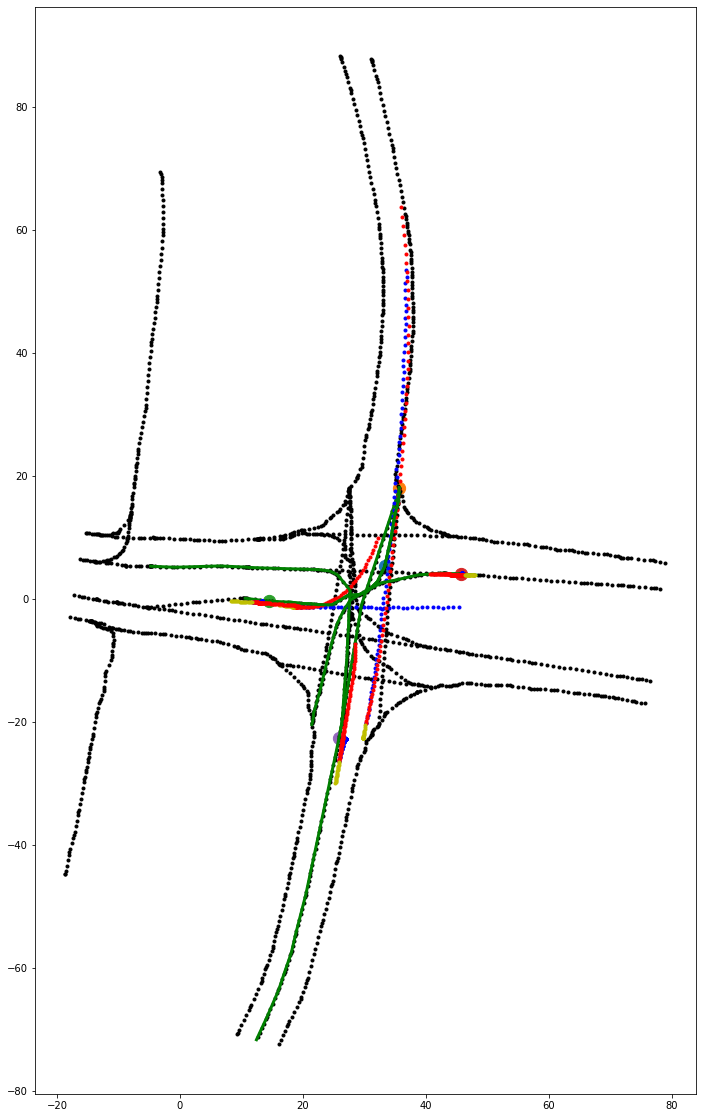

tensor(12.2976, device='cuda:0')
tensor(11.3374, device='cuda:0')
tensor(13.8346, device='cuda:0')
tensor(14.5507, device='cuda:0')
tensor(14.0611, device='cuda:0')


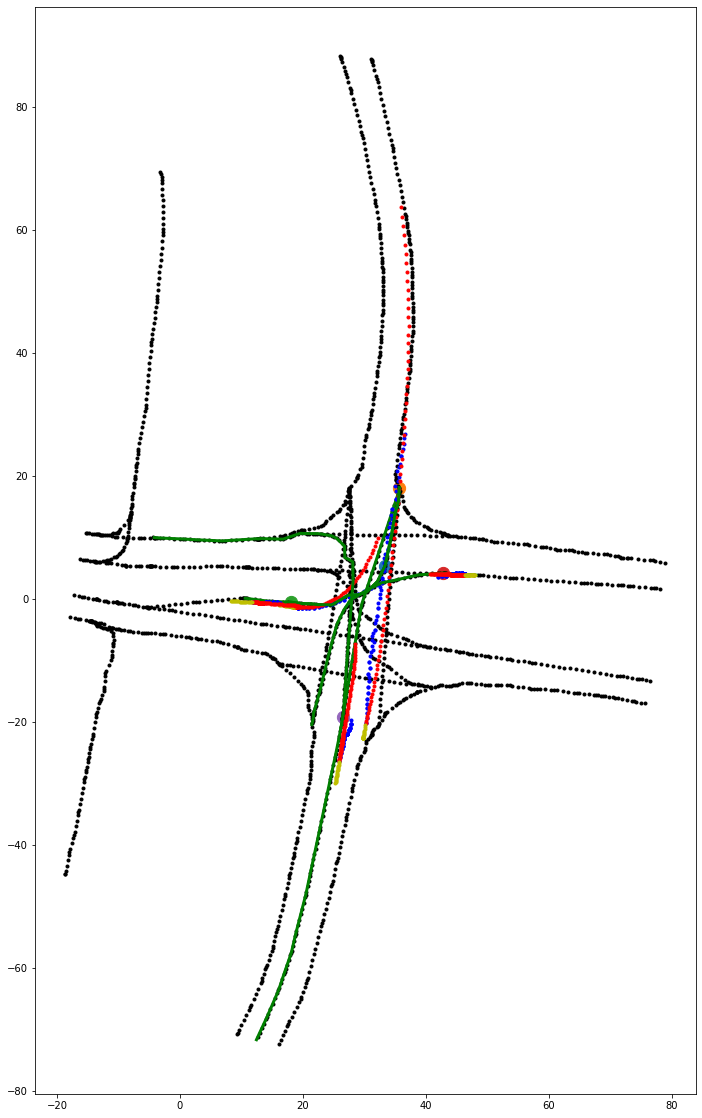

tensor(12.2945, device='cuda:0')
tensor(11.1787, device='cuda:0')
tensor(13.7235, device='cuda:0')
tensor(14.4573, device='cuda:0')
tensor(13.9618, device='cuda:0')


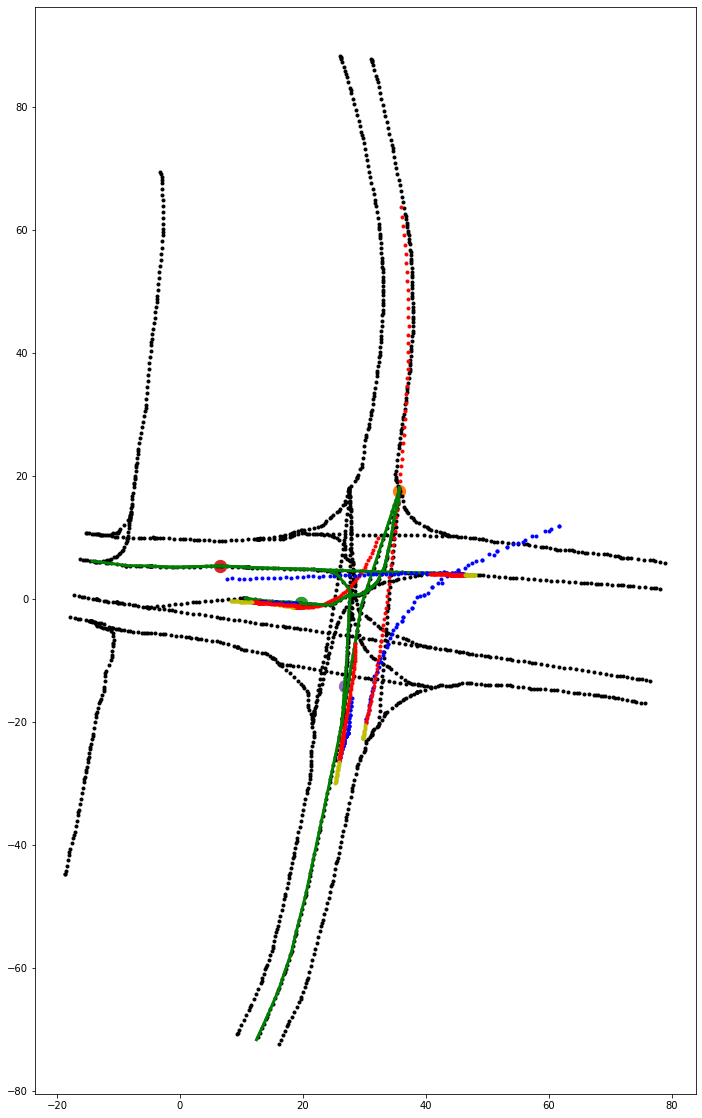

tensor(12.2229, device='cuda:0')
tensor(11.0914, device='cuda:0')
tensor(13.6633, device='cuda:0')
tensor(14.4309, device='cuda:0')
tensor(13.7233, device='cuda:0')


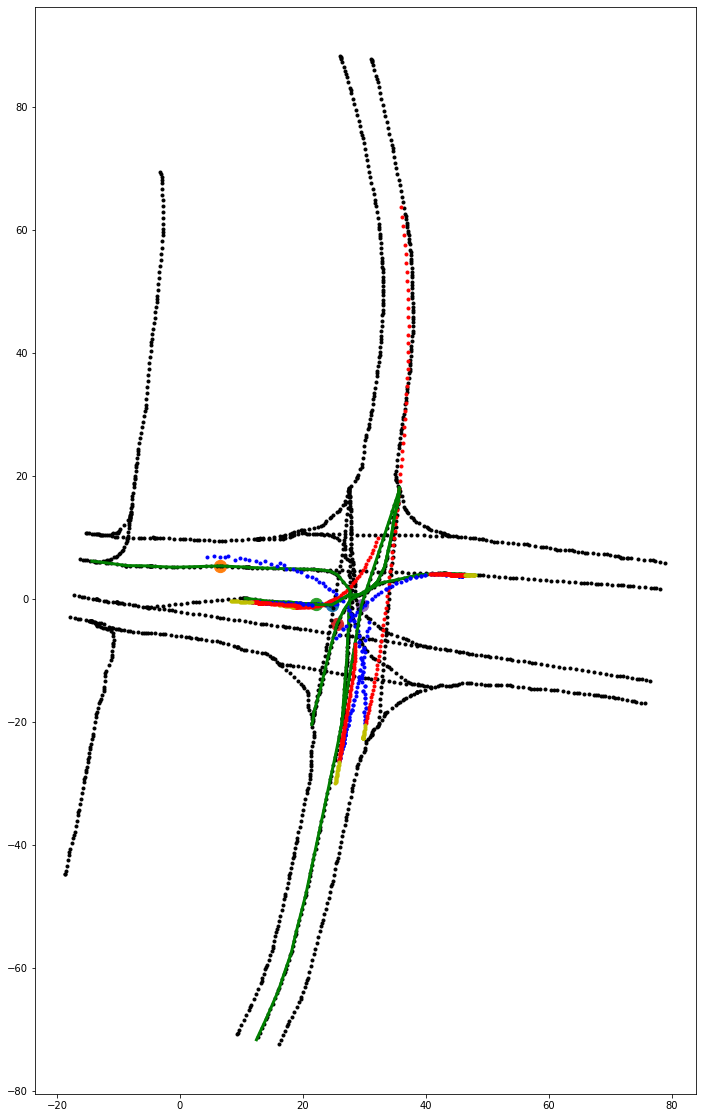

tensor(12.1689, device='cuda:0')
tensor(10.9933, device='cuda:0')
tensor(13.6003, device='cuda:0')
tensor(14.3908, device='cuda:0')
tensor(13.6631, device='cuda:0')


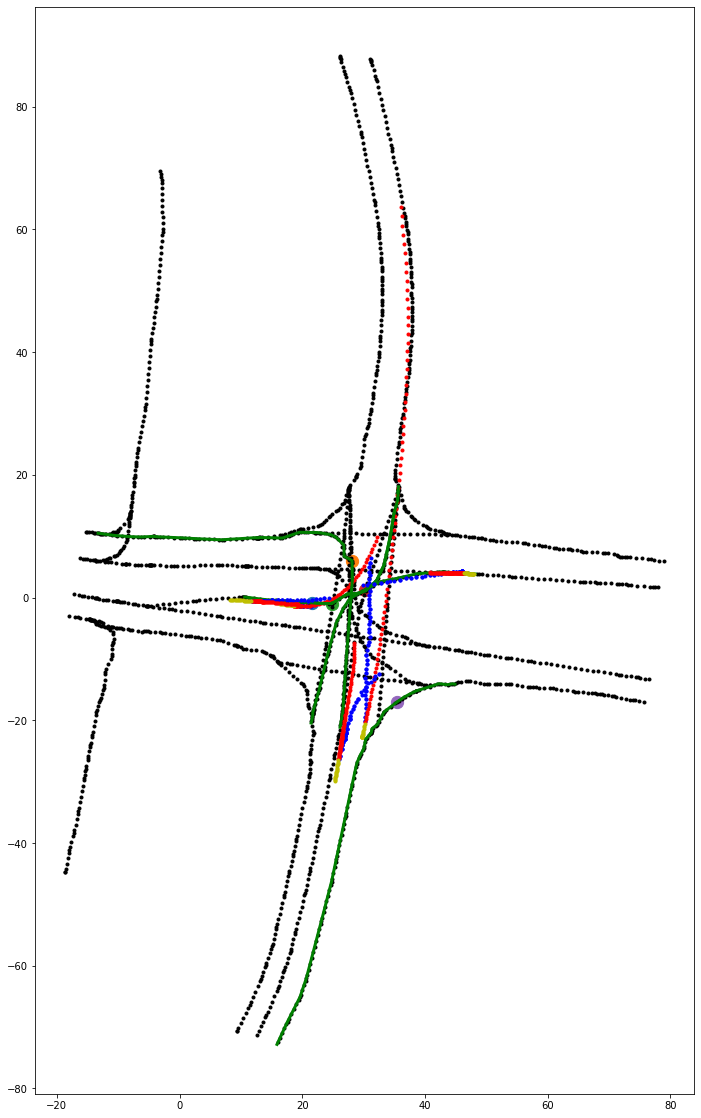

tensor(12.1298, device='cuda:0')
tensor(10.5848, device='cuda:0')
tensor(13.5141, device='cuda:0')
tensor(14.1608, device='cuda:0')
tensor(13.5022, device='cuda:0')


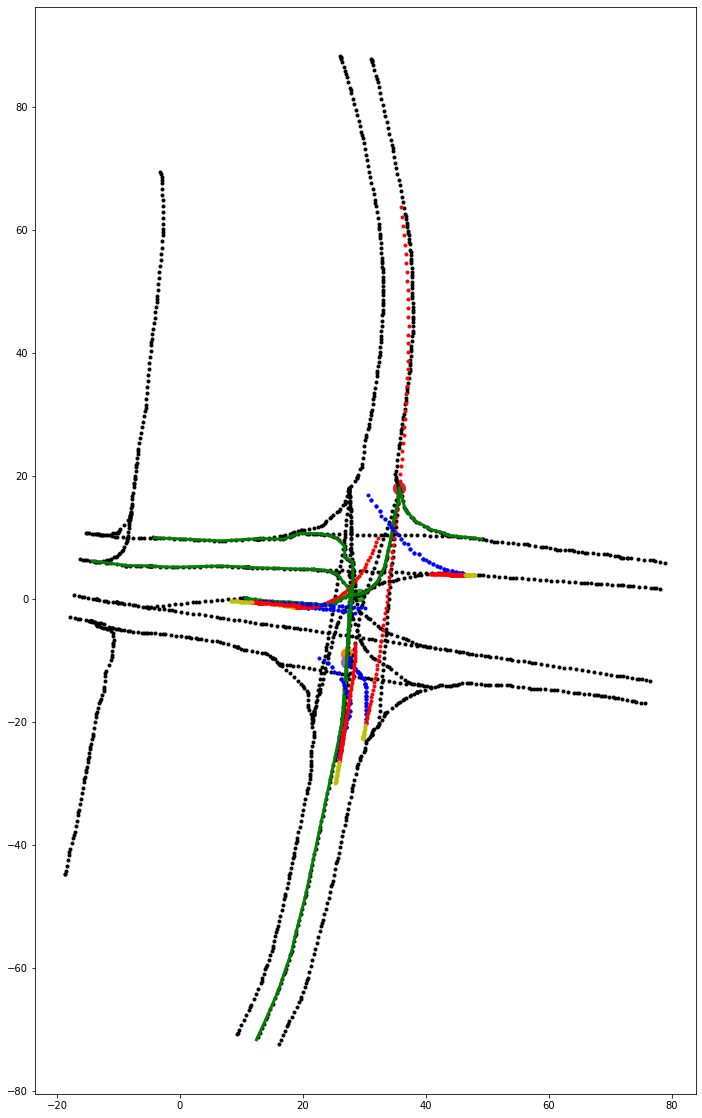

In [353]:
import numpy as np
import matplotlib.pyplot as plt
idx = 5
thrd = 0.5


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(data['gt_preds'][idx].shape[0]):
#         if a != 1:
#             continue
        
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
#         plt.plot(hist[:, 0], hist[:, 1], 'y.')
        for l in data['ref_paths'][idx][a]:
            lane = torch.matmul(l - data['orig'][idx], rot.T)
#             plt.plot(lane[:, 0], lane[:, 1], 'g')
#         traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
        for i in range(1, pred_traj.shape[0]):
            if dis(pred_traj[i][0], pred_traj[i - 1][0], pred_traj[i][1], pred_traj[i - 1][1]) < thrd:
                results[idx][a, k][i] = results[idx][a, k][i - 1]
#         traj_plot(pred_traj, rot, orig, ax, 'b.')
        print(output['cls'][idx][a][k])
        
        
        traj = torch.matmul(output['reg'][idx][a][k].cpu() - data['orig'][idx], rot.T)
        diff = traj[1:] - traj[:-1]
#         S_pred = torch.sum(torch.sqrt(torch.sum(diff ** 2, axis=1)))

        min_final_dis = float('inf')
        min_final_lane = None
        min_final_pt = None
        for ref in data['ref_paths'][idx][a]:
            if ref is None:
                continue
            
            Lane = torch.matmul(ref - data['orig'][idx], rot.T)
            map_car0 = Lane - traj[-1]
            lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))
#             plt.plot(Lane[:, 0], Lane[:, 1], 'g')

            final_pt = Lane[lane_end_id]
#             plt.scatter(final_pt[0], final_pt[1], s=150)
        
            final_dis = torch.sqrt(torch.sum((final_pt - traj[-1]) ** 2))
#             print(final_pt, traj[-1], final_dis)
            if min_final_dis > final_dis:
                min_final_dis = final_dis
                min_final_lane = Lane
                min_final_pt = final_pt
            
        plt.plot(min_final_lane[:, 0], min_final_lane[:, 1], 'g', linewidth=3)
        
        traj_plot(pred_traj, rot, orig, ax, 'b.')
        traj_plot(gt_pred,  rot, orig, ax, 'r.')
        plt.plot(hist[:, 0], hist[:, 1], 'y.')

        plt.scatter(min_final_pt[0], min_final_pt[1], s=150)
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
    plt.savefig('/home/user/Logs/0722/test/laneloss' + str(idx) + '_' + str(k))
    plt.show()


In [208]:
data['shapes'][idx]

tensor([[2.0600, 4.9200],
        [1.9300, 4.6400],
        [1.9400, 4.7700],
        [1.8500, 4.0600],
        [2.0200, 4.9500]])

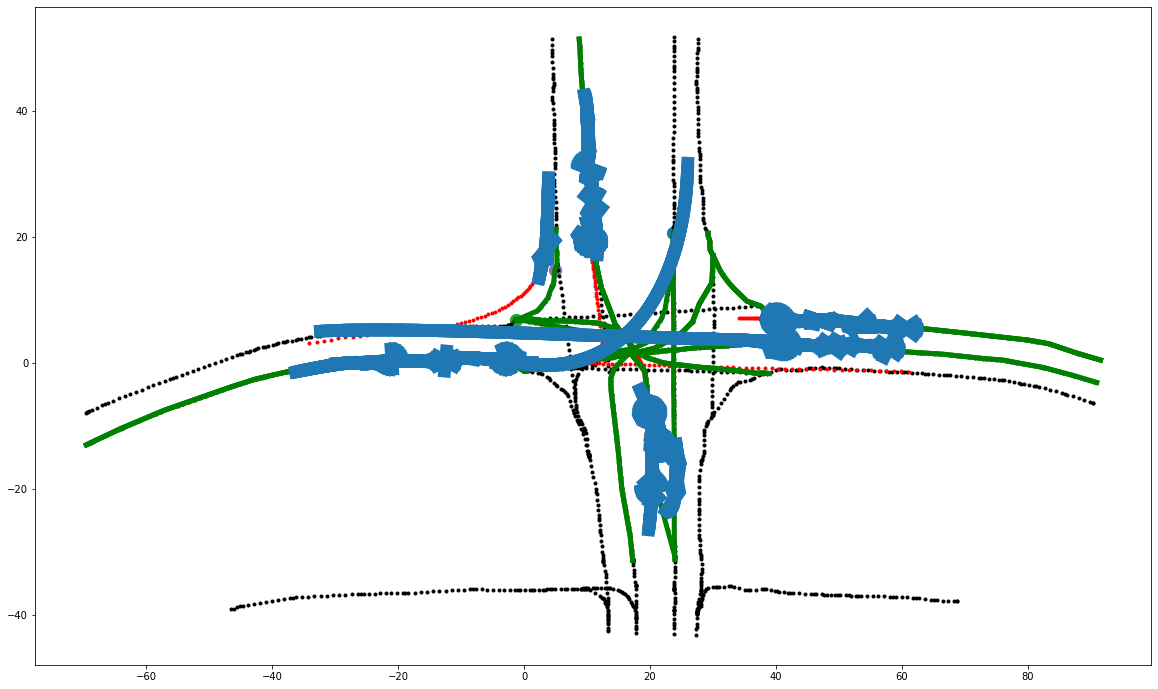

In [318]:
k = 0

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib.patches import Polygon,Circle
from matplotlib.collections import PatchCollection


def rect_plot(pos, rot, orig, w, l, ax, c):
    rot = rot.numpy()
    orig = orig.numpy()    

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline

def polygon_xy_from_motionstate(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center


import csv

csv_file = '/home/user/Projects/interaction_gyt/recorded_trackfiles/DR_USA_Intersection_EP0/vehicle_tracks_000.csv'
widths = {}
lengths = {}
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        track_id = row[0]
        if track_id not in widths:
            widths[track_id] = row[10]
            lengths[track_id] = row[9]


            
import numpy as np
import matplotlib.pyplot as plt
# idx = 3


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

fig, ax = plt.subplots(1,1, figsize=(20, 20))
ax.set_aspect('equal', adjustable='box')

ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')


res_final_dis, res_final_lane, res_final_pt = [], [], []
entire_trajs = np.zeros([gt_preds.shape[0], 20 + config['pred_size'], 3])
for a in range(gt_preds.shape[0]):
    width, length = data['shapes'][idx][a]

    mask = has_preds[a]
    gt_pred = gt_preds[a][mask]

    hist = data['feats'][idx][a][:,:2]
    pred_traj = traj_plot(results[idx][a, k, :, :], rot, orig)
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_pred,  rot, orig, ax, 'r.')
    
    sp_hist = spline5(hist.numpy()[:, 0], hist.numpy()[:, 1])
    pred_traj[0] = hist[-1]
    sp_pred = spline5(pred_traj[:, 0], pred_traj[:, 1])

    hist_T = hist.shape[0]
    for time_stamp in range(hist_T):
        x, y, dx, dy = sp_hist.cal(time_stamp / (hist_T - 1))
        entire_trajs[a, time_stamp, 0] = x
        entire_trajs[a, time_stamp, 1] = y
        entire_trajs[a, time_stamp, 2] = math.atan2(dy, dx)
        
    for time_stamp in range(config['pred_size']):
        x, y, dx, dy = sp_pred.cal(time_stamp / (config['pred_size'] - 1))
        entire_trajs[a, hist_T + time_stamp, 0] = x
        entire_trajs[a, hist_T + time_stamp, 1] = y
        entire_trajs[a, hist_T + time_stamp, 2] = math.atan2(dy, dx)
        
    min_final_dis = float('inf')
    min_final_lane = None
    min_final_pt = None
    
    for ref in data['ref_paths'][idx][a]:
        if ref is None:
            continue

        Lane = torch.matmul(ref - data['orig'][idx], rot.T)
        map_car0 = Lane - pred_traj[-1]
        lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))
    #             plt.plot(Lane[:, 0], Lane[:, 1], 'g')

        final_pt = Lane[lane_end_id]
    #             plt.scatter(final_pt[0], final_pt[1], s=150)

        final_dis = torch.sqrt(torch.sum((final_pt - pred_traj[-1]) ** 2))
    #             print(final_pt, traj[-1], final_dis)
        if min_final_dis > final_dis:
            min_final_dis = final_dis
            min_final_lane = Lane
            min_final_pt = final_pt
            
    res_final_dis.append(min_final_dis)
    res_final_lane.append(min_final_lane)
    res_final_pt.append(min_final_pt)
        
    plt.plot(min_final_lane[:, 0], min_final_lane[:, 1], 'g', linewidth=5)
    plt.scatter(min_final_pt[0], min_final_pt[1], s=150)

for time_stamp in range(entire_trajs.shape[1]):
    for a in range(gt_preds.shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


# ax.plot(entire_traj[:, 0], entire_traj[:, 1], 'b.')
    

#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Videos/0603/8s/' + str(idx) + '_' + str(k))
plt.show()

In [319]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation():
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots(1,1, figsize=(20, 20))

#   plt.gca().invert_xaxis()
#   plt.gca().invert_yaxis() 
    

  ax.set_aspect('equal', adjustable='box')
    
  plt.ion()
  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

  for a in range(data['gt_preds'][idx].shape[0]):
    hist = data['feats'][idx][a][:,:2]
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_preds[a],  rot, orig, ax, 'r.')
    
    plt.plot(res_final_lane[a][:, 0], res_final_lane[a][:, 1], 'g', linewidth=5)
    plt.scatter(res_final_pt[a][0], res_final_pt[a][1], s=150)
    

  def animate_func(time_stamp):
    ax.patches = []
    
    for a in range(data['gt_preds'][idx].shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


  anim = animation.FuncAnimation(
      fig, animate_func, frames=20+config['pred_size'], interval=100)
  plt.close(fig)
    
  return anim

anim = create_animation()
HTML(anim.to_html5_video())

CPU times: user 33 s, sys: 396 ms, total: 33.4 s
Wall time: 37.3 s


In [ ]:
torch.softmax(output['cls'][0], -1)

In [ ]:
output['cls']

In [ ]:
torch.arange(prediction.shape[0])
prediction.get_device()

In [ ]:
from metrics import compute_joint_metrics
compute_joint_metrics(prediction, truth, [])

In [ ]:
import csv
from tqdm import tqdm

csv_prefix = '/home/user/Downloads/collected_id_pair'
csv_folders = os.listdir(csv_prefix)

larger_than_5s = 0
files_5s = []

larger_than_8s = 0
files_8s = []

larger_than_10s = 0
files_10s = []

total_count = 0

for folder in tqdm(csv_folders):
    csv_path = os.path.join(csv_prefix, folder)
    for name in os.listdir(csv_path):
        csv_file = os.path.join(csv_path, name)
#         print(csv_file)

        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            for i in reader:
                total_count += 1
#                 print(i[3], i[4], i[5])
                if int(i[5]) - int(i[4]) > 5000:
                    larger_than_5s += 1
                    files_5s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 8000:
                    larger_than_8s += 1
                    files_8s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 10000:
                    larger_than_10s += 1
                    files_10s.append([i[3:]])


In [ ]:
print('5s ', larger_than_5s)
print('8s ', larger_than_8s)
print('10s', larger_than_10s)
total_count

In [ ]:
print(entire_trajs[a].shape)
Xseq = entire_trajs[a][:, 0]
Yseq = entire_trajs[a][:, 1]

# print(Xseq)
# print(Yseq)
# spx = spline5(Xseq)
# spy = spline5(Yseq)

# spx.cal(1)
# spy.cal(1)

# spx.plot_scatter()
# spy.plot_scatter()

sp = spline5(Xseq, Yseq)
print(sp.cal(0.0))
print(sp.cal(1.0))
sp.plot_scatter()

In [102]:
# from cvxopt  import solvers, matrix
import numpy as np
from qpsolvers import solve_qp
from numpy import array, dot
import sympy as sym
import math 

class spline5:
    def __init__(self, Xseq, Yseq, yaw=None):
        self.Xseq = Xseq
        self.Yseq = Yseq
        
        self.T = len(Xseq)
        order = 5
        self.order = order
        
        p = np.zeros([self.T * 2, (order + 1) * 2])
        q = np.zeros([self.T * 2, 1])
        for i in range(self.T):
            t = i / (self.T - 1)
            for j in range(order + 1):
                ttt = np.power(t, j)
                p[i][j] = ttt
                p[i + self.T][j + order + 1] = ttt
            q[i] = Xseq[i]
            q[i + self.T] = Yseq[i]
        
        bound = 2
###### -b <= d2y/d2x <= b
        g = np.zeros([self.T * 2, (order + 1) * 2])
        h = np.zeros([self.T * 2])
        for i in range(self.T):
            t = i / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g[i][j]                 = -bound * j * (j-1) * ttt
                g[i][j + order + 1]     = j * (j-1) * ttt            
                
                g[i + self.T][j]        = -bound * j * (j-1) * ttt
                g[i + self.T][j + order + 1] = -j * (j-1) * ttt
        

####### -b <= d2x/d2y <= b
        g2 = np.zeros([self.T * 2, (order + 1) * 2])
        h2 = np.zeros([self.T * 2])
        for i in range(self.T):
            t = i / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g2[i][j]                      = j * (j-1) * ttt            
                g2[i][j + order + 1]          = -bound * j * (j-1) * ttt
                
                g2[i + self.T][j]             = -j * (j-1) * ttt
                g2[i + self.T][j + order + 1] = -bound * j * (j-1) * ttt
        

####### 
        


        
#         np.set_printoptions(precision=2)
#         print('p', p)
#         P = np.dot(p.T, p) + np.dot(g.T, g) * 0.001 + np.eye((order + 1) * 2) * 0.0001
        P = np.dot(p.T, p) + np.eye((order + 1) * 2) * 0.01
        
        Q = -np.dot(q.T, p)
        Q = Q.reshape(((order + 1) * 2,))
        
        A = np.zeros([3, (order + 1) * 2])
        B = np.zeros([A.shape[0], 1])
        
        A[0][0] = 1
        A[1][order + 1] = 1
        B[0] = Xseq[0]
        B[1] = Yseq[0]
        
#         for j in range(order + 1):
#             A[2][j] = 1
#             A[3][j + order + 1] = 1
#         B[2] = Xseq[-1]
#         B[3] = Yseq[-1]
        
        if yaw is not None:
            A[-1][1] = math.tan(yaw) 
            A[-1][1+order+1] = -1

            B[-1] = 0
            
        B = B.reshape((A.shape[0],))
        
        
        G = np.concatenate([g, g2])
        H = np.concatenate([h, h2])
                
#         self.sol = solve_qp(P=P, q=Q)
        self.sol = solve_qp(P=P, q=Q, A=A, b=B)
#         self.sol = solve_qp(P=P, q=Q, A=A, b=B, G=G, h=H)



    def cal(self, t):
        x = 0
        y = 0
        order = self.order
        dx = 0
        dy = 0
        
        if t >= 0 and t <= 1:
            for i in range(order + 1):
                ttt = np.power(t, i)
                x += self.sol[i] * ttt
                y += self.sol[i + order + 1] * ttt

            for i in range(1, order + 1):    
                ttt = np.power(t, i - 1)
                dx += self.sol[i] * i * ttt
                dy += self.sol[i + order + 1] * i * ttt
        
        return x, y, dx, dy

    def plot_scatter(self):
        X, Y = [], []

        T = [i / (self.T - 1) for i in range(self.T)]
        for t in T:
            x, y, dx, dy = self.cal(t)
            X.append(x)
            Y.append(y)

            
        plt.scatter(T, X)
        plt.scatter(T, self.Xseq, color='red')
        plt.show()        
#     
        plt.scatter(T, Y)
        plt.scatter(T, self.Yseq, color='red')
        plt.show()

        plt.scatter(X, Y)
        plt.scatter(self.Xseq, self.Yseq, color='red')
        plt.show()

# sp = spline5(Xseq[::1], Yseq[::1])


In [ ]:
print(graph.keys())
print(data.keys())
print(graph['ctrs'].shape)
print(data['ctrs'][0].shape)

In [ ]:
print(graph['suc'][0]['u'].shape)
print(graph['suc'][0]['u'])

In [ ]:
ego_id = 1
data['ctrs'][0][ego_id]

In [ ]:
graph.keys()
lane_id = graph['lane_idcs'][ego_graph_id]
print("start point ctr id", lane_id)

torch.nonzero(graph['lane_idcs']==lane_id)

In [ ]:
def dfs(cur_graph_id, Lanes, lane, cur_len, S_pred, iter):
    graph_u = graph['suc'][0]['u']
    graph_v = graph['suc'][0]['v']
    
    suc_indices = (graph_u==cur_graph_id).nonzero()
    if cur_len > S_pred or suc_indices.shape[0] == 0 or iter > 100:
        Lanes.append(torch.stack(lane).long())
        print(cur_len, S_pred)
        print(Lanes[-1])
        return 
    
    for suc_id in suc_indices:
        lane.append(graph_v[suc_id[0]])
        
        s_diff = graph['ctrs'][graph_v[suc_id[0]]] - graph['ctrs'][graph_u[suc_id[0]]]
        s = torch.sqrt(torch.sum(s_diff ** 2))
#         print(s.numpy())
        dfs(graph_v[suc_id[0]], Lanes, lane, cur_len + s, S_pred, iter+1)
        lane.pop()

In [ ]:
Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred=100, iter=0)
frenet_lane = graph['ctrs'][Lanes[0]]
# print(frenet_lane)
# print(graph['ctrs'][ego_graph_id])

In [ ]:
ego_id = 1
k=3

pred = results[idx][ego_id][k]
diff = np.diff(pred, axis=0)
S_pred = np.sum(np.sqrt(np.sum(diff ** 2, axis=1)))

print(graph['ctrs'])
print(data['ctrs'][idx][ego_id, :])
map_car0 = graph['ctrs'] - data['ctrs'][idx][ego_id, :]
# map_car0 = graph['ctrs'] - torch.Tensor(np.array([990.57, 983.906]))
start = torch.sum(map_car0 ** 2, 1)

graph_u = graph['suc'][0]['u']
graph_v = graph['suc'][0]['v']

ego_graph_id = torch.argmin(start)
# ego_graph_id = 1281

print(ego_graph_id)
graph['ctrs'][ego_graph_id]
gt_preds.shape

fig, ax = plt.subplots(1,1, figsize=(40,40))
ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     
# for a in range(data['gt_preds'][idx].shape[0]):
#     mask = has_preds[a]
#     gt_pred = gt_preds[a][mask]

#     hist = data['feats'][idx][a]
# #     plt.plot(hist[:, 0], hist[:, 1], 'y.')
# #     traj_plot(gt_pred,  rot, orig, ax, 'r.')

#     pred_traj = results[idx][a, k, :, :]
traj_plot(results[idx][ego_id][k], rot, orig, ax, 'b.')
    
traj_plot(gt_preds[ego_id],  rot, orig, ax, 'r.')


ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred, iter=0)
for Lane in Lanes:
    frenet_lane = graph['ctrs'][Lane]
    ax.plot(frenet_lane[:, 0], frenet_lane[:, 1], 'g*')
ax.plot([graph['ctrs'][ego_graph_id][0]], [graph['ctrs'][ego_graph_id][1]], 'r*')


plt.show()